Demo Model Performance: R²=0.2495, RMSE=2.0468


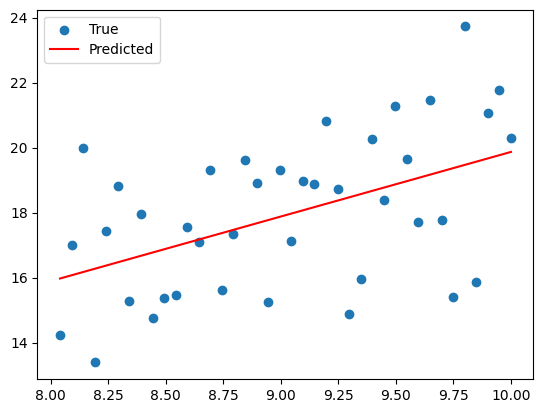

Reloaded model test prediction: [9.92947345]
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/Aug/2025 22:10:13] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2025 22:10:13] "GET /predict/7.0 HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2025 22:10:13] "GET /plot HTTP/1.1" 200 -


POST /predict: {'prediction': 9.929473447790441}
GET /predict/<input1>: {'prediction': 13.903852118132711}



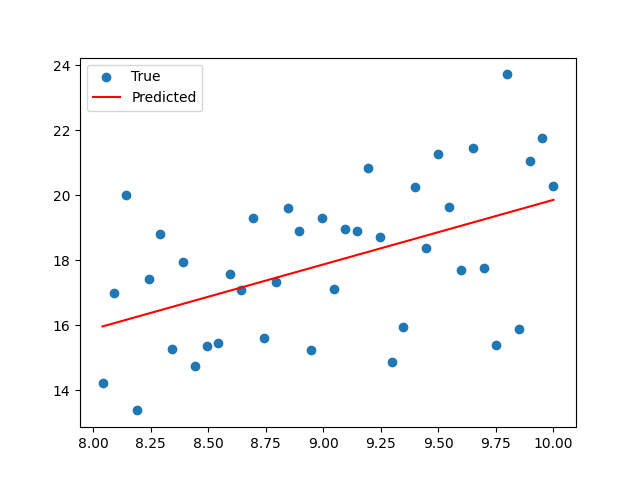

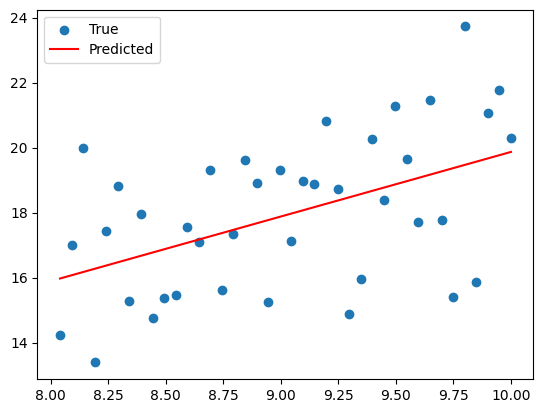

In [ ]:
# 1. Create mock, very basic analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import os, pickle

np.random.seed(7)


n = 200
X = np.linspace(0, 10, n).reshape(-1, 1)
y = 2 * X.squeeze() + np.random.normal(0, 2, n)


split = int(n*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Demo Model Performance: R²={r2:.4f}, RMSE={rmse:.4f}")

plt.scatter(X_test, y_test, label="True")
plt.plot(X_test, y_pred, color="red", label="Predicted")
plt.legend()
plt.show()


# 2. modeling presistence

os.makedirs("model", exist_ok=True)

with open("model/model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("model/model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("Reloaded model test prediction:", loaded_model.predict([[5]]))


# 3. Flask endpoint
from flask import Flask, request, jsonify
import threading, io, base64
import matplotlib.pyplot as plt

app = Flask(__name__)
with open("model/model.pkl", "rb") as f:
    model = pickle.load(f)

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json()
    features = data.get("features", None)
    if features is None:
        return jsonify({"error": "No features provided"}), 400
    try:
        pred = model.predict([features])
    except Exception as e:
        return jsonify({"error": str(e)}), 400
    return jsonify({"prediction": float(pred[0])})

@app.route("/predict/<float:input1>")
def predict_one(input1):
    pred = model.predict([[input1]])
    return jsonify({"prediction": float(pred[0])})

@app.route("/plot")
def plot():
    fig, ax = plt.subplots()
    ax.scatter(X_test, y_test, label="True")
    ax.plot(X_test, y_pred, color="red", label="Predicted")
    ax.legend()
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    img_bytes = base64.b64encode(buf.read()).decode("utf-8")
    return f'<img src="data:image/png;base64,{img_bytes}"/>'

def run_flask():
    app.run(port=5000)

threading.Thread(target=run_flask).start()


# 4. Testing the Flask API from Notebook
import requests
from IPython.display import display, HTML


resp = requests.post("http://127.0.0.1:5000/predict", json={"features":[5.0]})
print("POST /predict:", resp.json())


resp2 = requests.get("http://127.0.0.1:5000/predict/7.0")
print("GET /predict/<input1>:", resp2.json())

resp3 = requests.get("http://127.0.0.1:5000/plot")
display(HTML(resp3.text))
